In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines


# At the start season, assume zero infections -- all from external sources

In [6]:
capT = 1000
Input_H = [1500,0,0,0]
parameters = [Input_H, capT] 

### Gillespie on SEIR with external function (assume step function)
Assume no births and deaths during outbreak

In [7]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial) # SEIR
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    Rtotal = 1
    while Rtotal>0:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]   

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        
########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0: # Susceptible to Exposed (via external forcing)
                num_external +=1
            if event == 1: # Susceptible to Infected (human to human transmission)
                num_internal +=1
            if event == 2: # Exposed to Infected
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal

# Perform ABC on 2004 data

Fit the following parameters in SEIR model to the 2004 outbreak data:
- $\beta$ human to human transmission
- $\varepsilon$ external force of infection
- $\mu_1$ recovery from the disease
- $\mu_2$ death due to disease
- $\sigma$ rate of transition from exposed to infected

In [9]:
Data_F10=pd.read_csv("../../Case_data/2010_faridpur_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
    start_day = (datetime.strptime(dataset['Date'].values[0], date_format)-datetime.strptime('01/11/09', date_format)).days
    record = [int(a - record[0]) for a in record]
    record = [int(a +start_day) for a in record]

    return record

Rec_F10=Spacing(Data_F10)
summary = np.array([Rec_F10, Data_F10['CumsumInf'].values])



# Initial Tolerance - guess suitable parameters and find error (take to be initial tolerance)

Run gillespie algorithm to produce cumulative infections against time and return error from the euclidean distance with real data.

In [15]:
capT = 1000
Input_H = [1500,0,0,0]
parameters = [Input_H] 

β = 0.1
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/8 #5 days exposed
ϵ = 0.00001

In [40]:

M =gillespieSEIR_season(Input_H, β, μ1, μ2, σ, ϵ)
time = [] #make results of M a step function
cuminf = [] #steps
infections = []
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
        infections.append((M[1][:,2][ind], M[1][:,2][ind]))
    else:
        time.append((M[0][ind], M[0][ind]))
        cuminf.append((M[3][ind], M[3][ind]))
        infections.append((M[1][:,2][ind], M[1][:,2][ind]))

time2 = np.array(time).flatten()
time = np.array(time).flatten()

cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))


summary_time = summary[0]
summary_cum = summary[1]
if max_time> max(summary_time):
    length1 =  np.arange(max(summary_time), max_time +1, 2)
    summary_time = np.append(summary_time, length1)
    summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
if max_time < max(summary_time):
    length2 = np.arange(max_time, max(summary_time)+1, 2)
    time = np.append(time,length2)
    cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
inter_cum = np.interp(inter_t, time,cuminf) #daily steps

print('initial tolerance', np.linalg.norm(summary_cum-inter_cum[summary_time])) #Error -- initial tolerance

initial tolerance 15.716233645501712


/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


([<matplotlib.axis.XTick at 0x7fa836ab50b8>,
 <a list of 6 Text xticklabel objects>)

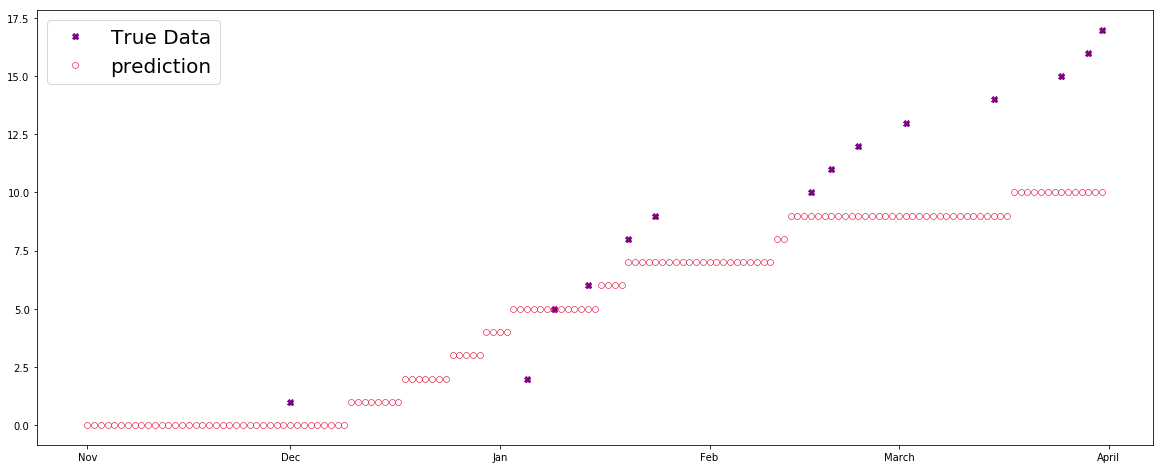

In [43]:

plt.figure(figsize = (20,8))
plt.plot(summary_time, summary_cum,  'X', color = 'purple', label = 'True Data')
plt.plot(inter_t, inter_cum, 'o',markeredgewidth=0.6, markeredgecolor='crimson',markerfacecolor='None', label = 'prediction')
plt.legend(fontsize = 20)

plt.xticks([0,30, 30+31, 30+31+31, 30+31+31+28, 30+31+31+28+31
           ], ['Nov','Dec', 'Jan', 'Feb', 'March', 'April'])

# Adaptive (tolerance reduces with each iteration) ABC

In [32]:
N = 50 # Number of particles to draw 
tol = 87.4
t = 0 
θ = []
# prior distributions
β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0.1,1, N), np.random.uniform(0,0.00001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]

θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1) #draw parameters from prior
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR_season(Input_H, βt, μ1t,μ2t,σt,ɛt)
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
        else:
            time.append((M[0][ind], M[0][ind]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    

    summary_time = summary[0]
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 3)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    

    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
#         print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N: # When accepted N particles, update tolerance (adaptive ABC) and priors
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
#         print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

In [269]:
# np.save('theta_Season_F10', θ)
# np.save('tols_Season_F10', tols)

# RESULTS OF ABC

In [44]:
θ = np.load('theta_Season_F10.npy')
tols = np.load('tols_Season_F10.npy')

### Plots of prior distribution reducing with each tolerance step (y axis)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


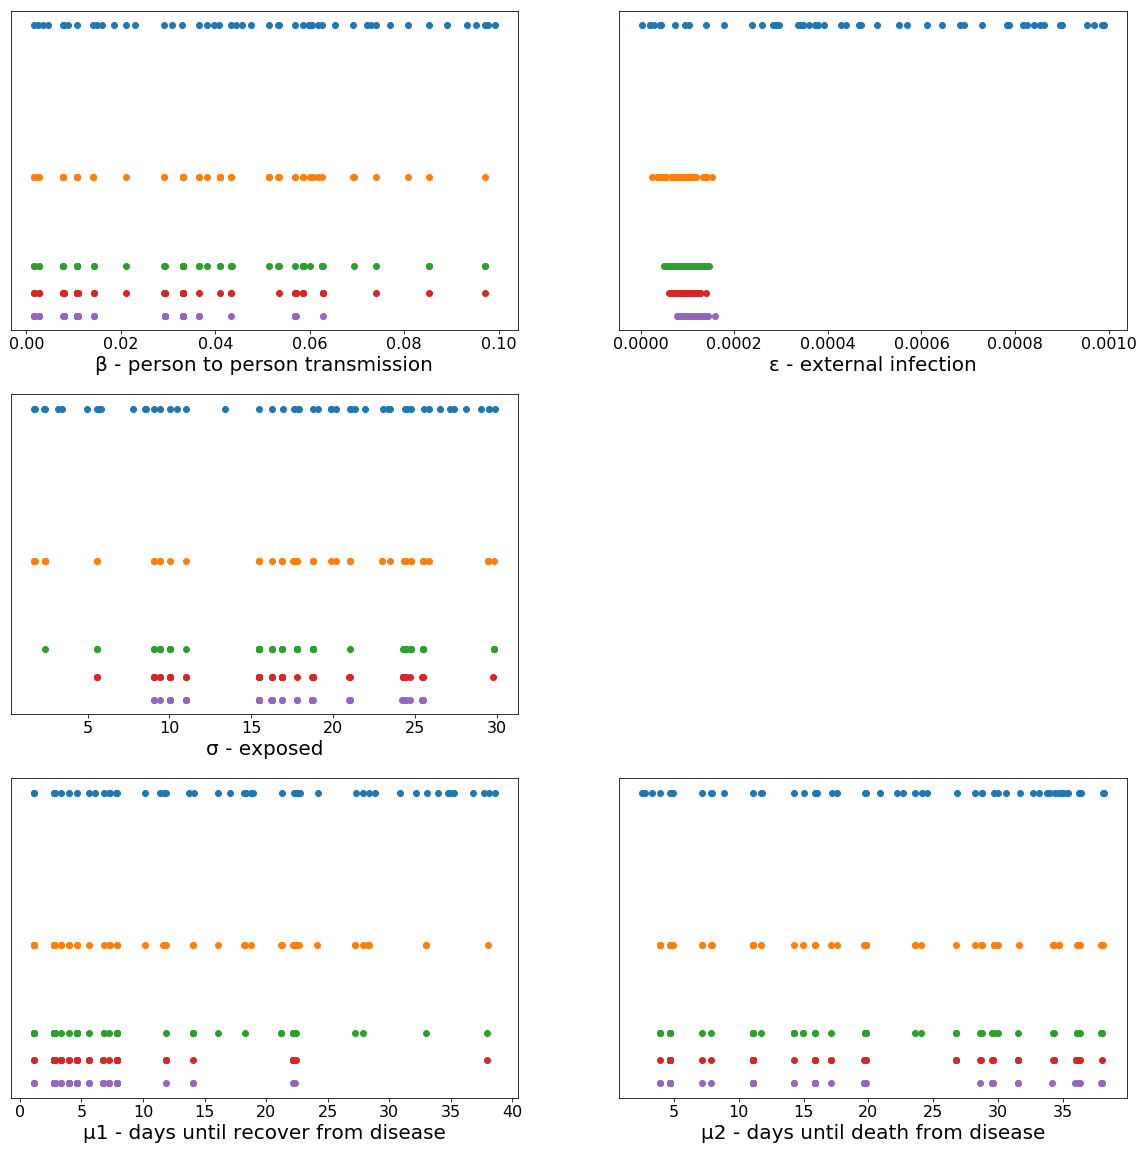

In [45]:
plt.figure(figsize = (20,20))
for i in range(5):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)
    


### plot of prior distribution and posterior distribution

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 9 Text xticklabel objects>)

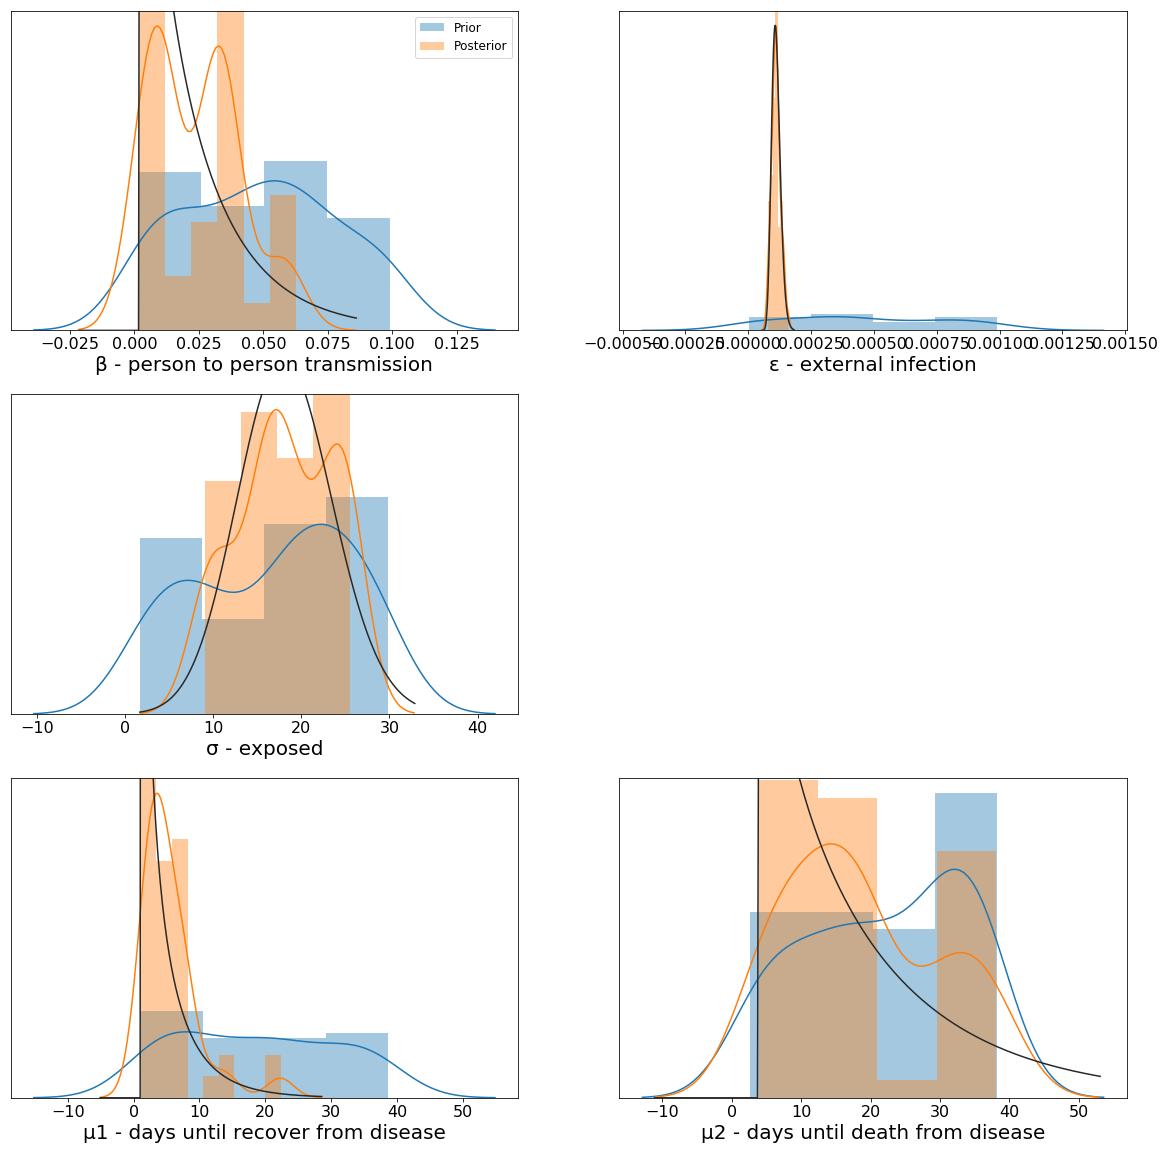

In [46]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[4][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.legend(fontsize = 12)
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[4][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[4][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[4][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[4][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

# Test the parameter distributions

Fit a gamma distribution to the posterior distributions

In [47]:
a_β, loc_β, scale_β = stats.gamma.fit(θ[5][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[5][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[5][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[5][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[5][:,4]])

In [76]:
timing = []
cumulative = []
for k in range(8000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR_season(Input_H, beta, mu1,mu2,
                          sigma,epsilon)
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
        else:
            time.append((M[0][ind], M[0][ind]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))

    summary_time = Rec_F10
    summary_cum = Data_F10['CumsumInf'].values
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
        summary_cum = np.append(summary_cum, max( Data_F10['CumsumInf'].values)*np.ones(len(length1 )))
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    timing.append(inter_t)
    cumulative.append(inter_cum)

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


In [77]:
len_outbreak = Rec_F10[-1]
Num_sim = 1000
mat = np.zeros(shape=(Num_sim, len_outbreak))
cumulative = np.array(cumulative)

# Take the true mode of the simulations

In [85]:
ma = []
for k in range(len(cumulative)):
    ma.append(len(cumulative[k]))
mat = np.zeros(shape=(Num_sim, max(ma)))
for k in range(Num_sim):
    if len(cumulative[k]) < max(ma):
        mat[k,:] = np.concatenate([cumulative[k], cumulative[k][-1]*np.ones(max(ma) - len(cumulative[k]))])
    else:
        mat[k,:] = cumulative[k]

(0, 100)

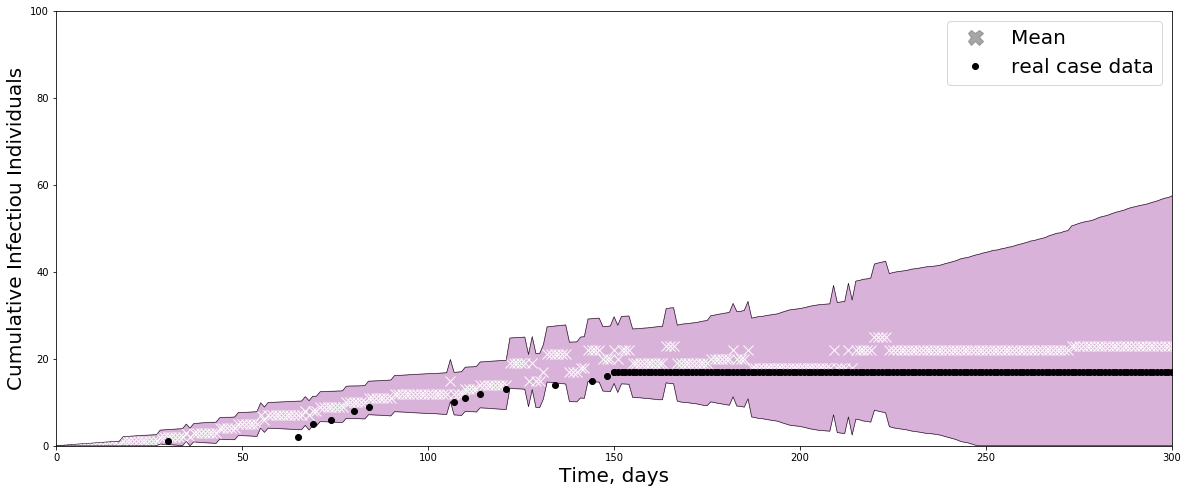

In [86]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(max(ma)), stats.mode(mat, axis = 0)[0][0], 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mode')
plt.plot(range(max(ma)), (stats.mode(mat, axis = 0)[0][0]+np.std(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(max(ma)), np.maximum((stats.mode(mat, axis = 0)[0][0]-np.std(mat, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(range(max(ma)),  (stats.mode(mat, axis = 0)[0][0]+np.std(mat, axis = 0)), np.maximum((stats.mode(mat, axis = 0)[0][0]-np.std(mat, axis = 0)),0), 1, alpha=0.3, color = 'purple')
true, = ax.plot(summary_time, summary_cum, 'o', color = 'black', label = 'real case data')
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)

blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mean')
plt.legend(handles=[blue_line, true], fontsize = 20)
plt.xlim([0,300])
plt.ylim([0,100])

# Take mode of predicted density

In [98]:
modes = []
for k in range(len(mat[0,:])):
    if k == 0:
        modes.append(0)
    else:
#         loc_param, scale_param = stats.norm.fit(mat[:,k])
#         param_density = stats.norm.pdf(x, loc=loc_param, scale=scale_param)
#         modes.append(x[np.argsort(param_density)[-1]])
        nparam_density = stats.kde.gaussian_kde(mat[:,k])
        x = np.linspace(-20, 60, 500)
        nparam_density = nparam_density(x)
        modes.append(x[np.argsort(nparam_density)[-1]])

(0, 100)

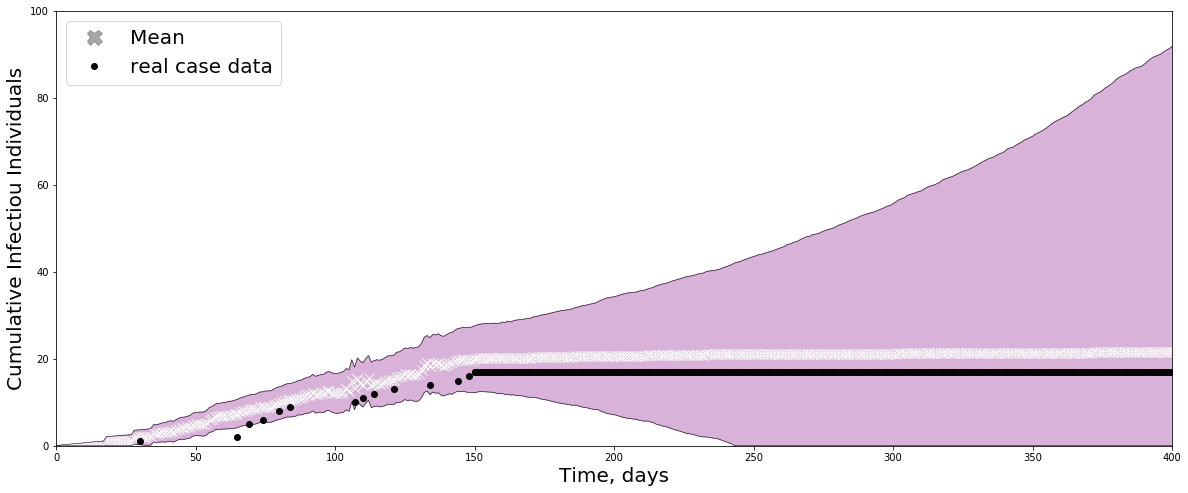

In [106]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(max(ma)), modes, 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mode')
plt.plot(range(max(ma)), (modes+np.std(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(max(ma)), np.maximum((modes-np.std(mat, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(range(max(ma)),  (modes+np.std(mat, axis = 0)), np.maximum((modes-np.std(mat, axis = 0)),0), 1, alpha=0.3, color = 'purple')
true, = ax.plot(summary_time, summary_cum, 'o', color = 'black', label = 'real case data')
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)

blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mean')
plt.legend(handles=[blue_line, true], fontsize = 20)
plt.xlim([0,400])
plt.ylim([0,100])

# Return error between true data and mode of 8000 replications

In [107]:
def returnerror(timestep, cum, sumstat1, sumstat2):
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(timestep):
        if ind < len(timestep)-1:
            time.append((timestep[ind], timestep[ind+1]))
            cuminf.append((cum[ind], cum[ind]))
        else:
            time.append((timestep[ind], timestep[ind]))
            cuminf.append((cum[ind], cum[ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    

    summary_time = sumstat1
    summary_cum = sumstat2
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
        summary_cum = np.append(summary_cum, max(sumstat2)*np.ones(len(length1 )))
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) 
    return np.linalg.norm(summary_cum-inter_cum[summary_time]), inter_t, inter_cum

error 12.12503202224868


(0, 500)

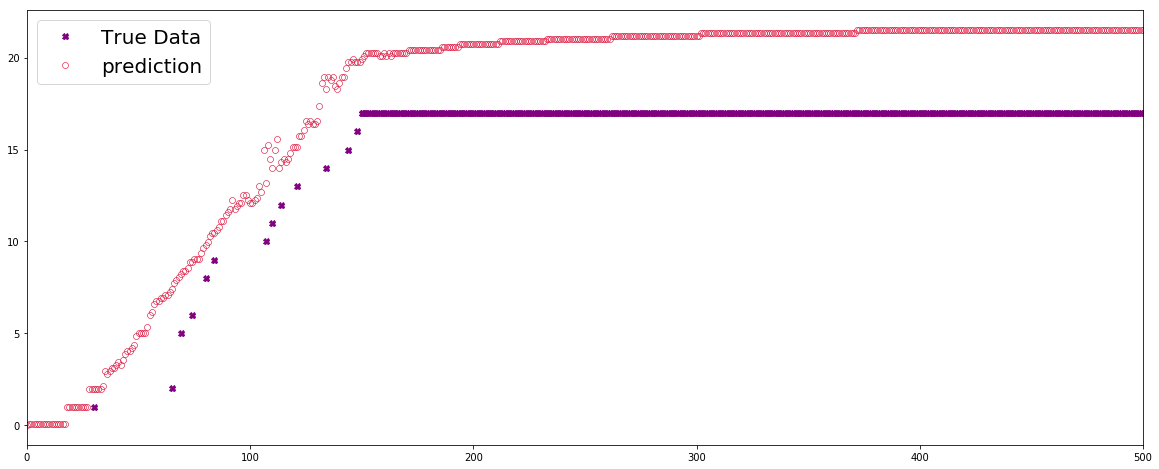

In [111]:
plt.figure(figsize = (20,8))
plt.plot(summary_time, summary_cum,  'X', color = 'purple', label = 'True Data')
plt.plot(range( max(ma)), modes,  'o',markeredgewidth=0.6, markeredgecolor='crimson',markerfacecolor='None', label = 'prediction')

error = returnerror(range(len_outbreak+1), modes, Rec_F10, Data_F10['CumsumInf'].values)[0]
print('error', error)
plt.legend(fontsize = 20)
plt.xlim([0,500])